<a href="https://colab.research.google.com/github/tubagus86/IYKRA-Fellowship/blob/master/RFM_and_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd # untuk membaca dataset
import numpy as np # untuk perhitungan statistik
import matplotlib.pyplot as plt # untuk visualisasi
import seaborn as sns # untuk visualisasi

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# membaca dataset

retail = pd.read_excel('Online Retail.xlsx')

In [3]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
print('{:,} rows; {:,} columns'.format(retail.shape[0], retail.shape[1]))

541,909 rows; 8 columns


In [6]:
# cek missing values

retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Drop missing values

retail.dropna(subset=['CustomerID'], inplace = True)

In [8]:
# cek missing values kembali

retail.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
# cek tahun yang ada pada dataframe

print('Orders from {} to {}'.format(retail['InvoiceDate'].min(),
                                      retail['InvoiceDate'].max()))

Orders from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


Pada dataframe, rentang waktu yang ada sejak tahun 2010 s/d 2011, kita akan melakukan RFM berdasarkan tahun tersebut selama 365 hari.

In [10]:
retail['Price'] = retail['Quantity'] * retail['UnitPrice']

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [11]:
retail.describe()

,Quantity,UnitPrice,CustomerID,Price
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,20.401854
std,248.693370,69.315162,1713.600303,427.591718
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,2.000000,1.250000,13953.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [12]:
# selanjutnya akan membuat variabel baru untuk melihat tingkatan pembelian

retail_order = retail.groupby(['InvoiceNo','InvoiceDate','CustomerID']).agg({'Price':lambda x:x.sum()}).reset_index()

retail_order.head()

,InvoiceNo,InvoiceDate,CustomerID,Price
0,536365,2010-12-01 08:26:00,17850.0,139.12
1,536366,2010-12-01 08:28:00,17850.0,22.20
2,536367,2010-12-01 08:34:00,13047.0,278.73
3,536368,2010-12-01 08:34:00,13047.0,70.05
4,536369,2010-12-01 08:35:00,13047.0,17.85


In [13]:
# untuk melakukan analisa recency kita perlu membuat referensi date pada analisa kita, umumnya menggunakan 
# tanggal transaksi terakhir ditambah satu hari

from datetime import timedelta

reference_date = retail_order['InvoiceDate'].max()+timedelta(days=1)

reference_date

Timestamp('2011-12-10 12:50:00')

In [14]:
# kita akan melakukan analisa selama 1 tahun, untuk hal ini saya akan menggunakan jumlah harinya 365 hari

period = 365

- Analisa **RFM**

In [15]:
retail_order['LastDaysOrder'] = retail_order['InvoiceDate'].apply(lambda x: (reference_date-x).days)

retail_order.head()

,InvoiceNo,InvoiceDate,CustomerID,Price,LastDaysOrder
0,536365,2010-12-01 08:26:00,17850.0,139.12,374
1,536366,2010-12-01 08:28:00,17850.0,22.20,374
2,536367,2010-12-01 08:34:00,13047.0,278.73,374
3,536368,2010-12-01 08:34:00,13047.0,70.05,374
4,536369,2010-12-01 08:35:00,13047.0,17.85,374


In [16]:
agg_retail = {'LastDaysOrder':lambda x:x.min(),
              'InvoiceDate':lambda x:len([d for d in x if d >= reference_date - timedelta(days=period)]),}

In [17]:
rfm = retail_order.groupby('CustomerID').agg(agg_retail).reset_index()

rfm.head()

,CustomerID,LastDaysOrder,InvoiceDate
0,12346.0,326,2
1,12347.0,2,6
2,12348.0,75,4
3,12349.0,19,1
4,12350.0,310,1


In [18]:
rfm.rename(columns={'LastDaysOrder': 'Recency', 'InvoiceDate': 'Frequency'}, inplace=True)

rfm.head()

,CustomerID,Recency,Frequency
0,12346.0,326,2
1,12347.0,2,6
2,12348.0,75,4
3,12349.0,19,1
4,12350.0,310,1


In [19]:
rfm['Monetary'] = rfm['CustomerID'].apply(lambda x: retail_order[(retail_order['CustomerID'] == x) & \
                                                           (retail_order['InvoiceDate'] >= reference_date - timedelta(days=period))]\
                                                           ['Price'].sum())
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,6,3598.21
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [20]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 6.0},
 'Monetary': {0.2: 215.89800000000002,
  0.4: 440.432,
  0.6: 876.3679999999999,
  0.8: 1909.6580000000006},
 'Recency': {0.2: 11.0, 0.4: 32.0, 0.6: 71.0, 0.8: 178.80000000000018}}

In [21]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [22]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [23]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346.0,326,2,0.00,1,2,1
1,12347.0,2,6,3598.21,5,4,5
2,12348.0,75,4,1797.24,2,4,4
3,12349.0,19,1,1757.55,4,1,4
4,12350.0,310,1,334.40,1,1,2


In [24]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,6,3598.21,5,4,5,545
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


In [25]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)

rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,12346.0,326,2,0.00,1,2,1,121,hibernating
1,12347.0,2,6,3598.21,5,4,5,545,champions
2,12348.0,75,4,1797.24,2,4,4,244,at risk
3,12349.0,19,1,1757.55,4,1,4,414,promising
4,12350.0,310,1,334.40,1,1,2,112,hibernating


In [26]:
rfm['Segment'].value_counts()

hibernating            1271
loyal customers         793
champions               630
about to sleep          441
potential loyalists     432
at risk                 400
promising               167
need attention          111
can't loose              64
new customers            63
Name: Segment, dtype: int64

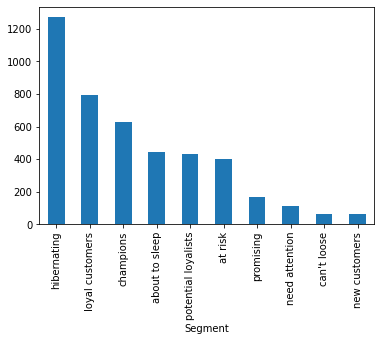

In [27]:
rfm.groupby(['Segment']).size().sort_values(ascending= False).plot.bar()

In [28]:
rfm_df = rfm[['Recency','Frequency','Monetary']]

scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4372, 3)

In [29]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Recency','Frequency', 'Monetary']
rfm_df_scaled.head()

,Recency,Frequency,Monetary
0,2.322023,-0.320408,-0.230460
1,-0.893733,0.126818,0.224150
2,-0.169196,-0.096795,-0.003391
3,-0.725005,-0.432215,-0.008405
4,2.163220,-0.432215,-0.188211


In [30]:
SSE = []

for cluster in range(2,8):
    kmeans = KMeans(n_clusters=cluster,random_state=42)

    kmeans.fit(rfm_df_scaled)
    
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(rfm_df_scaled)
    
    SSE.append(kmeans.inertia_)
    
frame = pd.DataFrame({'Cluster':range(2,8) , 'SSE':SSE})

frame.head()

,Cluster,SSE
0,2,9138.340033
1,3,5511.367944
2,4,4065.129328
3,5,2999.381793
4,6,2391.923196


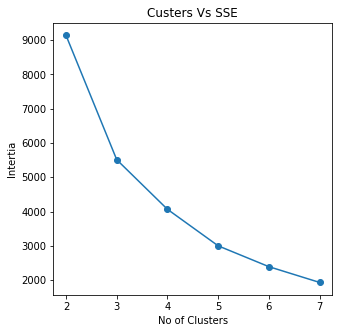

In [31]:
plt.figure(figsize=(5,5))
plt.plot(frame['Cluster'],frame['SSE'],marker='o')
plt.title('Custers Vs SSE')
plt.xlabel('No of Clusters')
plt.ylabel('Intertia')
plt.show()

In [32]:
kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(rfm_df_scaled)
pred = kmeans.predict(rfm_df_scaled)

In [33]:
rfm['Cluster'] = kmeans.labels_
rfm['Cluster'].value_counts()

1    3238
0    1112
2      22
Name: Cluster, dtype: int64

In [34]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment,Cluster
0,12346.0,326,2,0.00,1,2,1,121,hibernating,0
1,12347.0,2,6,3598.21,5,4,5,545,champions,1
2,12348.0,75,4,1797.24,2,4,4,244,at risk,1
3,12349.0,19,1,1757.55,4,1,4,414,promising,1
4,12350.0,310,1,334.40,1,1,2,112,hibernating,0


In [35]:
rfm_cluster = rfm[['Recency','Frequency','Monetary','Cluster']]

rfm_cluster

,Recency,Frequency,Monetary,Cluster
0,326,2,0.00,0
1,2,6,3598.21,1
2,75,4,1797.24,1
3,19,1,1757.55,1
4,310,1,334.40,0
...,...,...,...,...
4367,278,1,180.60,0
4368,181,1,80.82,0
4369,8,3,176.60,1
4370,4,16,2094.88,1


In [38]:
rfm_cluster.groupby('Cluster').head()

,Recency,Frequency,Monetary,Cluster
0,326,2,0.00,0
1,2,6,3598.21,1
2,75,4,1797.24,1
3,19,1,1757.55,1
4,310,1,334.40,0
5,36,11,1545.41,1
6,204,1,89.00,0
7,232,1,1079.40,0
8,214,1,459.40,0
9,23,3,2811.43,1
